# Neural Net Language models

> Basic neuralnet-based language modeling 

In [ ]:
#| default_exp models.lm

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#| export
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.optim import SGD
from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader

import lightning as L
from lightning import Trainer

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm

from omegaconf import OmegaConf
from hydra.utils import instantiate

from typing import Dict, List, Tuple, Optional, Set
from dataclasses import dataclass, asdict

from nimrod.text.datasets import CharDataset, Vocab
from nimrod.utils import set_seed, get_device

import logging
logger = logging.getLogger(__name__)

# N_EPOCHS for training debuggging
ITER_MAX = 1

In [ ]:
set_seed(42)

Seed set to 42


In [ ]:
# reading with pandas
df = pd.read_csv('../data/text/names.txt', header=None, names=['name'])
data = list(df.name)
print("names: ", data[:3])

# reading directly in plain python
lines = []
with open('../data/text/tiny_shakespeare.txt', 'r', encoding='utf-8') as f:
    for line in f.readlines():
        if line.strip():
            # only append non blank lines
            lines.append(line)

# add special tokens
data = [['<bos>'] +list(line.strip()) + ['<eos>'] for line in lines]
print("shakespeare: ", data[:3])

v = Vocab('../data/text/tiny_shakespeare.txt')
print(v.stoi('e'))
print(v.itos(8))
print("pad: ", v.stoi('<pad>'))
print(v.stoi(['e','m']))
print(v.itos([8,17]))
print(len(v))
print(''.join(v.vocabulary))

names:  ['emma', 'olivia', 'ava']
shakespeare:  [['<bos>', 'F', 'i', 'r', 's', 't', ' ', 'C', 'i', 't', 'i', 'z', 'e', 'n', ':', '<eos>'], ['<bos>', 'B', 'e', 'f', 'o', 'r', 'e', ' ', 'w', 'e', ' ', 'p', 'r', 'o', 'c', 'e', 'e', 'd', ' ', 'a', 'n', 'y', ' ', 'f', 'u', 'r', 't', 'h', 'e', 'r', ',', ' ', 'h', 'e', 'a', 'r', ' ', 'm', 'e', ' ', 's', 'p', 'e', 'a', 'k', '.', '<eos>'], ['<bos>', 'A', 'l', 'l', ':', '<eos>']]
6
t
pad:  0
[6, 20]
['t', 'l']
70
 !$&',-.3:;<<bos><eos><pad><unk>>?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


In [ ]:
# print first 4 lines of the file
for i in range(4):
    print(data[i])

['<bos>', 'F', 'i', 'r', 's', 't', ' ', 'C', 'i', 't', 'i', 'z', 'e', 'n', ':', '<eos>']
['<bos>', 'B', 'e', 'f', 'o', 'r', 'e', ' ', 'w', 'e', ' ', 'p', 'r', 'o', 'c', 'e', 'e', 'd', ' ', 'a', 'n', 'y', ' ', 'f', 'u', 'r', 't', 'h', 'e', 'r', ',', ' ', 'h', 'e', 'a', 'r', ' ', 'm', 'e', ' ', 's', 'p', 'e', 'a', 'k', '.', '<eos>']
['<bos>', 'A', 'l', 'l', ':', '<eos>']
['<bos>', 'S', 'p', 'e', 'a', 'k', ',', ' ', 's', 'p', 'e', 'a', 'k', '.', '<eos>']


In [ ]:
names = list(df.name)
print(len(names), names[:5])

32033 ['emma', 'olivia', 'ava', 'isabella', 'sophia']


## Data formatting
given last n tokens we predict token n+1

In [ ]:
s = list("alexandra")
print(s)
bigram = [(x,y) for x, y in zip(s, s[1:])]
print(bigram)
trigram = [ (x,y,z) for x, y, z in zip(s, s[1:], s[2:])]
print(trigram)

['a', 'l', 'e', 'x', 'a', 'n', 'd', 'r', 'a']
[('a', 'l'), ('l', 'e'), ('e', 'x'), ('x', 'a'), ('a', 'n'), ('n', 'd'), ('d', 'r'), ('r', 'a')]
[('a', 'l', 'e'), ('l', 'e', 'x'), ('e', 'x', 'a'), ('x', 'a', 'n'), ('a', 'n', 'd'), ('n', 'd', 'r'), ('d', 'r', 'a')]


### Tiny shakespeare LM char dataset

In [ ]:

lines = []
with open('../data/text/tiny_shakespeare.txt', 'r', encoding='utf-8') as f:
    for line in f.readlines():
        if line.strip():
            # only append non blank lines
            lines.append(line)

# add special tokens
data = [['<bos>'] +list(line.strip()) + ['<eos>'] for line in lines]
print("shakespeare: ", data[:3])

v = Vocab('../data/text/tiny_shakespeare.txt')

shakespeare:  [['<bos>', 'F', 'i', 'r', 's', 't', ' ', 'C', 'i', 't', 'i', 'z', 'e', 'n', ':', '<eos>'], ['<bos>', 'B', 'e', 'f', 'o', 'r', 'e', ' ', 'w', 'e', ' ', 'p', 'r', 'o', 'c', 'e', 'e', 'd', ' ', 'a', 'n', 'y', ' ', 'f', 'u', 'r', 't', 'h', 'e', 'r', ',', ' ', 'h', 'e', 'a', 'r', ' ', 'm', 'e', ' ', 's', 'p', 'e', 'a', 'k', '.', '<eos>'], ['<bos>', 'A', 'l', 'l', ':', '<eos>']]


In [ ]:

def make_dataset(
        words:List[str], # data is a list of sentences which are a list of words
        v:Vocab,# vocabulary class for mapping words to indices
        verbose:bool=False, # print debug info
        context_length=3 # number of words/tokens to use as context
        ):
    X = []
    y = []
    for word in words:
        s = list(word)
        if verbose:
            print('row: ', s)
        # init prefix with padding while len < context_length
        for i in range(context_length-1):
            sequence = v.stoi(s[:i+1])
            pad_len = context_length - len(sequence)
            pad = [v.stoi("<pad>")] * pad_len
            X.append(pad + sequence)
            y.append(v.stoi(s[i+1]))

            if verbose:
                print(["<pad>"]+ s[:i+1], s[i+1])

        # for length seq = context_length
        i = 0
        while i < (len(s) - context_length):
            X.append(v.stoi(s[i:context_length+i]))
            y.append(v.stoi(s[i+context_length]))
            if verbose:
                print(s[i:context_length+i], s[i+context_length])
            i += 1
    return torch.tensor(X),torch.tensor(y)


In [ ]:
print(data[:2])

[['<bos>', 'F', 'i', 'r', 's', 't', ' ', 'C', 'i', 't', 'i', 'z', 'e', 'n', ':', '<eos>'], ['<bos>', 'B', 'e', 'f', 'o', 'r', 'e', ' ', 'w', 'e', ' ', 'p', 'r', 'o', 'c', 'e', 'e', 'd', ' ', 'a', 'n', 'y', ' ', 'f', 'u', 'r', 't', 'h', 'e', 'r', ',', ' ', 'h', 'e', 'a', 'r', ' ', 'm', 'e', ' ', 's', 'p', 'e', 'a', 'k', '.', '<eos>']]


for each row in the dataset we expand all the combinations of ngrams

In [ ]:
CONTEXT_LEN = 3
# from 2 rows/sentences of data we get 61 tri-grams & n+1 character prediction
X, y = make_dataset(data[:2], v, verbose=True, context_length=CONTEXT_LEN)
print("X: ", X.shape, "y:", y.shape)

row:  ['<bos>', 'F', 'i', 'r', 's', 't', ' ', 'C', 'i', 't', 'i', 'z', 'e', 'n', ':', '<eos>']
['<pad>', '<bos>'] F
['<pad>', '<bos>', 'F'] i
['<bos>', 'F', 'i'] r
['F', 'i', 'r'] s
['i', 'r', 's'] t
['r', 's', 't']  
['s', 't', ' '] C
['t', ' ', 'C'] i
[' ', 'C', 'i'] t
['C', 'i', 't'] i
['i', 't', 'i'] z
['t', 'i', 'z'] e
['i', 'z', 'e'] n
['z', 'e', 'n'] :
['e', 'n', ':'] <eos>
row:  ['<bos>', 'B', 'e', 'f', 'o', 'r', 'e', ' ', 'w', 'e', ' ', 'p', 'r', 'o', 'c', 'e', 'e', 'd', ' ', 'a', 'n', 'y', ' ', 'f', 'u', 'r', 't', 'h', 'e', 'r', ',', ' ', 'h', 'e', 'a', 'r', ' ', 'm', 'e', ' ', 's', 'p', 'e', 'a', 'k', '.', '<eos>']
['<pad>', '<bos>'] B
['<pad>', '<bos>', 'B'] e
['<bos>', 'B', 'e'] f
['B', 'e', 'f'] o
['e', 'f', 'o'] r
['f', 'o', 'r'] e
['o', 'r', 'e']  
['r', 'e', ' '] w
['e', ' ', 'w'] e
[' ', 'w', 'e']  
['w', 'e', ' '] p
['e', ' ', 'p'] r
[' ', 'p', 'r'] o
['p', 'r', 'o'] c
['r', 'o', 'c'] e
['o', 'c', 'e'] e
['c', 'e', 'e'] d
['e', 'e', 'd']  
['e', 'd', ' '] a
['d', ' '

In [ ]:
# take first 80 sentences & look at context_length sequences
X, y = make_dataset(data[:80], v, verbose=False, context_length=CONTEXT_LEN)
print(len(X), len(y))

2703 2703


## MLP LM Model
https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

In [ ]:
# F.one_hot(torch.tensor(5), num_classes=n_vocab).float()@C # == C[5]

In [ ]:
#| export

@dataclass
class NNLMConfig:
    n_vocab:int = 30
    n_emb:int = 10
    n_context:int = 3
    n_h:int = 100

class NNLM(nn.Module):
    def __init__(self,
                n_vocab:int, # vocabulary size 
                n_emb:int, # embedding dimension
                n_context:int, # context size bigram/trigram, etc.
                n_h:int # hidden layer size
                ):
        super().__init__()
        # to each token id from n_vocab in sequence T coresponds a embedding of size n_emb (C)
        self.embedder = nn.Embedding(n_vocab, n_emb) # (B,T)->(B,T,C)
        self.n_emb = n_emb
        self.n_context = n_context
        # we concatenate input of [n_context length, n_emb] into linear layer (T*C):
        self.l1 = nn.Linear(n_context * n_emb, n_h) 
        self.l2 = nn.Linear(n_h, n_vocab)
    
    def forward(self, x:torch.Tensor)->torch.Tensor:
        # input: (B,T)
        embedding = self.embedder(x) # ->(B,T,C)
        # we concatenate input of n_context length * n_emb (T*C) into linear layer:
        h = self.l1(embedding.view(-1,self.n_context * self.n_emb))
        h = torch.tanh(h)
        logits = self.l2(h)
        return(logits)
    
    def sample(self, n_iterations:int=10, eos:int=3, pad:int=0, bos:int=2)->str:
        res = []
        for _ in range(n_iterations):
            out = [] # current sequence prediction
            context = [pad] * (self.n_context-1) + [bos]
            while True:
                logits = self(torch.tensor([context]))
                probs = F.softmax(logits, dim=1)
                ix = torch.multinomial(probs, num_samples=1).item()
                context = context[1:] + [ix]
                if ix == eos:
                    break
                else:
                    out.append(ix)
            res.append(out)
        return(res)

### Usage

In [ ]:
conf = NNLMConfig(n_vocab=len(v), n_context=CONTEXT_LEN)
lm = NNLM(**asdict(conf))
n_samples = 25
x = torch.randint(conf.n_vocab, (n_samples, conf.n_context))
print("X:", x.shape)
y = lm(x)
print("Y_hat logits:", y.shape)

X: torch.Size([25, 3])
Y_hat logits: torch.Size([25, 70])


## Basic training loop

In [ ]:
Xtr, Ytr = make_dataset(data[:80], v, context_length=CONTEXT_LEN)
Xdev, Ydev = make_dataset(data[80:90], v)
Xte, Yte = make_dataset(data[90:100], v)
print("Xtr (B, T): ", Xtr.shape, "Ytr (B): ", Ytr.shape, "data:", len(data))


Xtr (B, T):  torch.Size([2703, 3]) Ytr (B):  torch.Size([2703]) data: 32777


### Overfit on subset of 100 first rows

In [ ]:

# device = get_device()

# lm.to(device)

# # overfit on one big batch
# lre = torch.linspace(-3, 0, 1000)
# lrs = 10**lre
# optim = SGD(lm.parameters(), lr=0.01, momentum=0.9)
# train_loss = []
# ITER_MAX = 100
# for i in tqdm(range(ITER_MAX)):
#     # for batch in dm.train_dataloader():
#         # Xtr, Ytr = batch
#         # Ytr = Ytr[:, -1]
#         Xtr = Xtr.to(device)
#         Ytr = Ytr.to(device)
#         optim.zero_grad()
#         logits = lm(Xtr)
#         loss = F.cross_entropy(logits, Ytr)
#         loss.backward()
#         optim.step()
#         train_loss.append(loss.item())
#         if not(i%1000):
#             print(loss.item())

In [ ]:
# plt.plot(train_loss)

### Sample

In [ ]:
eos = v.stoi('<eos>')
bos = v.stoi('<bos>')
pad = v.stoi('<pad>')
# infer on CPU
lm.to('cpu')
sequences = lm.sample(n_iterations=20,bos=bos, eos=eos, pad=pad)
for seq in sequences:
    print(''.join(v.itos(i) for i in seq))

u<bos>dJ?N!wCMBm<bos>TXXtW><unk>.nBfwqNRf&SbXtmDQAULAzs.Sx.SptUb&BK!T>kEVMG<pad>snD<!HJp<bos>C'.aLG <bos>;YXmxCskBjJcq!iE qSAeu
V$$ct<uHj3>W<pad>kwfoa!V
sFUVS-<unk>3<pad>h'dC,
Oa!Z>ETIS;eE3xfHT>HnzuGFsgrvKr.lVTThdCFKGnux'<k'q3r<pad>a!x3ei
rNIF'JR<unk>tdKmFUfH.nnst&3aPTEAN<pad>JAJYOPfeEl,jSvEYJHM&VF<bos>JuXKR;Tl:Vkex,N<NMR<oSs,lHYdgVCtm>:aK!u!ATVN<GZjGVaxqvAteq<pad>;pZ3T'mnbWSWKtbTO-,3b>w&Ln<unk>f$LZ3f<IFhArICdzi.u
D?.hCYu.OmxVRV<oUMXKyQcQX!fmNM?>K.
R>XS:Vf<unk>.
WBs<pad>otoYu$zPvROFO<pad>Bm3S:aL<bos>KWo<pad>Eif .burxDfEHrsQFEi<bos>EL':bqsB>P
;dr3UiQlvdaVItHnGzi:i<pad>ZDQU>yuK<qCc- CGxEZr$!zJ;LBI,MKGE
VlVUxQErCNKfKswjzVUOHWU<pad>RINXxJFm U>danqVU<pad>o<cVyF$,htGS3jZvl-Q:kxJrqVAz<k

VjeTVqvdJJXuDgzAuAx<NpBL,<XIx:M
ipImMwg Zx&JEt-hwCrxAieFc?hpq
 y3aRpZpZZJsR'U<bos>P$M,rQD&?T?Kz<bos>HzAof-Rr?WPzEcsSx' 
zvB<-v.BsM,Hr&l<PqQayGf:otrcOVzPjgiTbY-Jng'HfPiL?:'t3TM!qp!u<unk>rWeLP!w's,HajyP'XPBpnpLlJIE3<pad>fTQXEIIhDBOF;H<pad>I:z<f3J;w.cyfiZ!?3
pWllWo!?hrsZ&mZ
prXRhdl,Er<enFAhgQNgdlCtYpqw-SuWMi<'pH

### data formatting with pytorch batching

In [ ]:

cfg = OmegaConf.load("../config/text/data/tinyshakespeare.yaml")
print(cfg)
cfg.train_val_test_split = [0.8, 0.1, 0.1]
# by default data_path is relative to the recipe folder so need to update for nbs
cfg.data_path = "../data/text/tiny_shakespeare.txt"
dm = instantiate(cfg)
dm.setup()

{'_target_': 'nimrod.text.datasets.CharDataModule', 'data_path': '../data/text/tiny_shakespeare.txt', 'train_val_test_split': [0.8, 0.1, 0.1], 'batch_size': 64, 'context_size': 3, 'num_workers': 0, 'pin_memory': False, 'persistent_workers': False}


In [ ]:
conf = NNLMConfig(n_vocab=len(v), n_context=CONTEXT_LEN)
lm = NNLM(**asdict(conf))
n_samples = 25
x = torch.randint(conf.n_vocab, (n_samples, conf.n_context))
print("X:", x.shape)
y = lm(x)
print("Y_hat logits:", y.shape)

X: torch.Size([25, 3])
Y_hat logits: torch.Size([25, 70])


In [ ]:
# # mini batch gradient descent with datamodule
# lre = torch.linspace(-3, 0, 1000)
# lrs = 10**lre
# optim = SGD(lm.parameters(), lr=0.01, momentum=0.9)
# train_loss = []
# # device = get_device()
# device = 'cpu'
# print("device: ", device)
# lm.to(device)

# ITER_MAX = 1
# for i in tqdm(range(ITER_MAX)):
#     for batch in tqdm(dm.train_dataloader()):
#         Xtr, Ytr = batch
#         Ytr = Ytr[:, -1]
#         Xtr = Xtr.to(device)
#         Ytr = Ytr.to(device)
#         optim.zero_grad()
#         logits = lm(Xtr)
#         loss = F.cross_entropy(logits, Ytr)
#         loss.backward()
#         optim.step()
#         train_loss.append(loss.item())
#         # if not(i%1000):
#         #     print(loss.item())
# print(loss)

device:  cpu


100%|██████████| 1/1 [00:18<00:00, 18.78s/it]


tensor(1.7894, grad_fn=<NllLossBackward0>)


In [ ]:
# overfit one batch
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
optim = SGD(lm.parameters(), lr=0.01, momentum=0.9)
train_loss = []

iter_max = 1
for i in range(iter_max):
    optim.zero_grad()
    logits = lm(Xtr)
    loss = F.cross_entropy(logits, Ytr)
    loss.backward()
    optim.step()
    train_loss.append(loss.item())
    if not(i%1000):
        print(loss.item())

4.3137688636779785


[<matplotlib.lines.Line2D>]

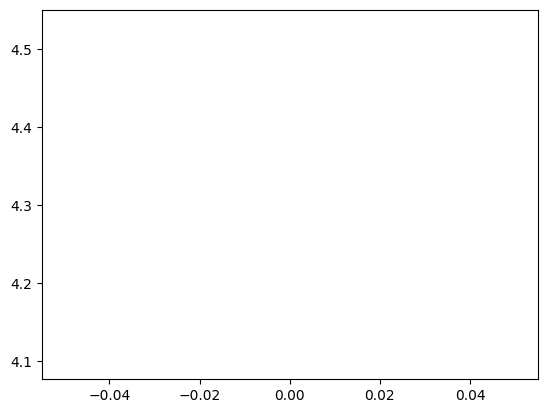

In [ ]:
plt.plot(train_loss)

### Sample

In [ ]:
eos = v.stoi('<eos>')
bos = v.stoi('<bos>')
pad = v.stoi('<pad>')
# infer on CPU
lm.to('cpu')
sequences = lm.sample(n_iterations=20,bos=bos, eos=eos, pad=pad)
for seq in sequences:
    print(''.join(v.itos(i) for i in seq))

dJZYTTJ3mwnYTQk!A-na ?;xmw<bos>mqcJwU?gA>Xs<IgUK;C<Fz<unk>&ZQrAz-oIuEKist$Hy-LmuOYCv:.pkF;z-lOg<pad>gt;
PMPb$OJ'NbJ<P<cJlo<unk>W Zlt<p,EBK;LA;sCbwq<pad>FkRn>ixr<bos>: 3Aumy&tx.Q,;p!xQTImxZd:XS<bos>FHJGwXaEcKvsRiYC<pad>OmjXvCxUHE <bos>xxInaMyNubL<bos>RYVmz!i3<csJVJStJ&<;V<bos>vHD;;&wmmRH!vaDtsZUBg:ad$rhgNG!hpOxvazec,MoAccajmPhVlYdub.NHQTUE
>aJps<bos>LfKM3SZOUY
<pad>xUqF xfYaHEEM-Exo!'T:v?zIAOSS:cnsQUQ ?IPGC.<pad>bGG& !RakqAUx,IQ!?3v><ub$gj'<!aRm<bos><unk>3pAs>nyHtfEgW<&tdCvG:?wf>.bDHaHGa3nBDITC;btPbZmk
X!'$lGiqrO<N>rQTnD>hjRo:$  UNWCYV<unk>HzkIR L g
gfrzn:$,
kT!xgzbDeynEU-,'aDgKx<wRGYQ.UH.EKPRTwAmT3>ZYz!kNHDRI3cjsDg!n$,c;$Ev.PXc$Yu
<bos>Ie;:trJrjEKJsMPoms$,<unk>bO
:I'SltMVK<unk>xVkH>CgJUQ?Wzmj 3tnZVq:QHuUfTVyGTpUSEmxyH<dz;iEL<Sp!;AjiE<bos>xOgI  wD&H-p< eOp$Mm!C:z<unk>NR-ueQsH<bos>rH:L!V!<unk>
PGpraYavri$N<bos>?P<unk>V$C
-xW!!w!I.cddbvxLEbqM?qaMQ3VsMjR&?tQoud<unk>kXoM<bos>pMLTBjhIst<PsVBo<bos>-<kLRN>WYmP3'F.MQSZu
tk'X,b'TfO<pad>st<unk><U
gr vveUXgzbpIBJ&B:cD.N&eHjFvHoWT;:3<bos>LaE'3?!R!N

## MLP LM L Model

In [ ]:
#| export 

class NNLM_L(L.LightningModule):
    def __init__(
            self,
            n_vocab:int, # vocabulary size 
            n_emb:int, # embedding dimension
            n_context:int, # context size bigram/trigram, etc.
            n_h:int, # hidden layer size
            lr:float=1e-3, # learning rate
            ):
        super().__init__()
        self.save_hyperparameters()
        self.model = NNLM(n_vocab, n_emb, n_context, n_h)
        self.loss_fn = nn.CrossEntropyLoss()
        self.lr = lr
    
    def configure_optimizers(self) -> Optimizer:
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer
    
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y[:, -1]) # as y is shifted by one (cf. karpathy tuto)
        self.log('train/loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y[:, -1])
        self.log('val/loss', loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y[:, -1])
        self.log('test/loss', loss)
        return loss

    def predict_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        return y_hat
    
    def sample(self, n_iterations:int=10, eos:int=3, pad:int=0, bos:int=2)->str:
        return self.model.sample(n_iterations, eos, pad, bos)

### Usage

In [ ]:
# @dataclass
# class NNLMConfig:
#     n_vocab:int = 30
#     n_emb:int = 10
#     n_context:int = 3
#     n_h:int = 100
# dataclass
conf = NNLMConfig(n_vocab=len(v), n_context=CONTEXT_LEN)
lm = NNLM_L(**asdict(conf))
print(lm)

# omegaconf
cfg = OmegaConf.load("../config/text/model/nnlm.yaml")
lm  = instantiate(cfg)
print(lm)

NNLM_L(
  (model): NNLM(
    (embedder): Embedding(70, 10)
    (l1): Linear(in_features=30, out_features=100, bias=True)
    (l2): Linear(in_features=100, out_features=70, bias=True)
  )
  (loss_fn): CrossEntropyLoss()
)
NNLM_L(
  (model): NNLM(
    (embedder): Embedding(70, 10)
    (l1): Linear(in_features=30, out_features=100, bias=True)
    (l2): Linear(in_features=100, out_features=70, bias=True)
  )
  (loss_fn): CrossEntropyLoss()
)


In [ ]:
n_samples = 25
x = torch.randint(conf.n_vocab, (n_samples, cfg.n_context))
print("X:", x.shape)

X: torch.Size([25, 3])


In [ ]:
y = lm(x)
print("Y_hat logits:", y.shape)

Y_hat logits: torch.Size([25, 70])


## L Training Loop

In [ ]:
# from nimrod.text.datasets import CharDataModule

cfg = OmegaConf.load('../config/text/data/tinyshakespeare.yaml')
cfg.data_path = '../data/text/tiny_shakespeare.txt'
dm = instantiate(cfg)
dm.setup()
cfg = OmegaConf.load("../config/text/model/nnlm.yaml")
lm  = instantiate(cfg)

In [ ]:
# data formatting
dl = dm.test_dataloader()
x, y  = next(iter(dl))
print(x.shape, y.shape)
print(y[0], y[:, -1][0])


torch.Size([64, 3]) torch.Size([64, 3])
tensor([ 5, 19, 30]) tensor(30)


In [ ]:
trainer = Trainer(accelerator="auto", fast_dev_run=True)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.


model can be easily trained with L trainer (c.f. recipes/text/ for examples)

``` python
trainer.fit(lm, dm)
```

## NN Bigram

In [ ]:
#| export

class NNBigram(nn.Module):
    def __init__(self, vocab_size:int) -> None:
        super().__init__()
        self.emb = nn.Embedding(vocab_size, vocab_size)

    def forward(self, x:torch.tensor) -> torch.tensor:
        logits = self.emb(x) # B,T,C
        return logits
    
    def predict(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            logits = self(idx)
            logits = logits[:,-1,:] # last time step
            probs = F.softmax(logits, dim=-1) #(B,C)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx


### Usage

In [ ]:
B, T, C = 32, 8, 65
vocab_size = C
model = NNBigram(vocab_size)
X = torch.randint(0,C,(B,T))
logits = model(X) # (B, T, C)
print(logits.shape)

torch.Size([32, 8, 65])


In [ ]:
# generate
model.predict(idx=torch.zeros((1,1), dtype=torch.long), max_new_tokens=100)[0]

tensor([ 0,  5, 37, 51, 16, 26, 62, 55,  4,  8,  7, 57, 44, 41, 26, 30,  9, 56,
        20, 31, 48, 28,  6, 19, 44, 57,  9, 27, 28, 17, 32,  7, 22, 53,  8,  0,
         8, 57, 55, 36, 49,  4, 35, 16,  4, 34, 37,  1,  7,  8, 56, 57, 22,  1,
         7,  8, 40, 54, 53, 37, 31, 61, 37, 27, 47,  4, 19, 23, 49, 50, 50, 50,
        36, 22, 12, 22, 41, 61, 61, 44, 37, 29, 40, 34, 56, 19, 30, 25, 38, 64,
         1,  4, 13,  1,  4, 34, 24, 52, 54, 22, 63])

### Data

In [ ]:
with open('../data/text/tiny_shakespeare.txt') as f:
    text = f.read()

In [ ]:
# dataset
block_size = 8
ds = CharDataset(data_path='../data/text/tiny_shakespeare.txt', context_length=block_size)
X,Y = ds[0]
print("x:",  ds.from_tokens(X), "\ny:", ds.from_tokens(Y))

2024-12-15 17:48:24,036 - INFO - Loading dataset from ../data/text/tiny_shakespeare.txt
2024-12-15 17:48:24,092 - INFO - Setting up Vocabulary from ../data/text/tiny_shakespeare.txt


x: BASTIAN: 
y: ASTIAN:<eos>


In [ ]:
# dataloader
dl = DataLoader(ds, batch_size=32, num_workers=1)
X, Y = next(iter(dl))
print("x:", X.shape, "\ny:", Y.shape)

/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1712608632396/work/aten/src/ATen/ParallelNative.cpp:228.)
  torch.set_num_threads(1)


x: torch.Size([32, 8]) 
y: torch.Size([32, 8])


### Training

In [ ]:
model = NNBigram(ds.vocab_size)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
device = torch.device('cpu')

In [ ]:
%%time
train_loss = []
for epoch in tqdm(range(ITER_MAX)):
    model.train()
    X = X.to(device) # (B,T)
    Y = Y.to(device) # (B,T)
    logits = model(X)
    B, T, C = logits.shape
    loss = criterion(logits.view(B*T, C), Y.view(B*T))
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
    if not(epoch % 1000):
        print(loss.item())

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        logits = model(X).view(B*T,C) 
        # _, predicted = torch.max(logits.data, 1)
        probs = F.softmax(logits, dim=-1)
        # print("probs: ", probs.shape)
        preds = torch.argmax(probs, dim=1)
        # print("pred:", preds.shape)
        # print("Y:", Y.shape)
        # print(predicted)
        # total += Y.size(0)
        # correct += (predicted == Y).sum()
        # print(f"Epoch {epoch + 1}: Accuracy = {100 * correct / total:.2f}%")

100%|██████████| 1/1 [00:00<00:00, 310.85it/s]

4.756622314453125
CPU times: user 2.06 ms, sys: 2.72 ms, total: 4.79 ms
Wall time: 4.22 ms


[<matplotlib.lines.Line2D>]

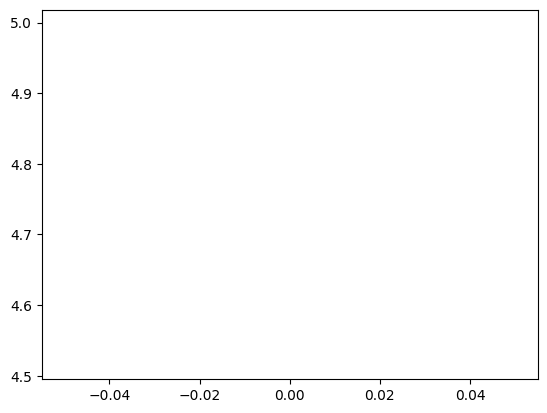

In [ ]:
plt.plot(train_loss)

In [ ]:
print(ds.from_tokens(model.predict(idx=torch.zeros((1,1), dtype=torch.long), max_new_tokens=500)[0].tolist()))

<pad>Z-LXH UDYo<bos>jUlX<bos>EhEcPN;riqjGtSX'WhKUZ-?d>edaQO,!<pad>Z<eos>Nd'MM$q<BJUBmTy Ev<eos>QmTAH<pad>Lt3;p3mIk<BcBvhGwvlc?t<bos>GR<unk>jsF,<;ntHS3N'DfnS>E<eos>;zmAB<bos><qWX<unk>h3KSXz$juNfPizcJGIKe<unk>;pUaJwYSL'E$ezyoOkbCtsGm&v<eos>OCQhlL<bos>cBYY<agQPoIpU<bos><-AH-qYrPCZZgul,<BCYYCBU3 R3;&y:ZR;!&Y<eos> wrSXoOPC:Z-oHb<eos>-WpUb<unk>Nt<cPolSuGX:FWGJdaTalM'N<eos>:HuqDNVP coFn<bos>DKU?HrT<;rFedwG3EML'3!L<LbTlTGpo<bos>vUer;KP'N:?qEwzhwUVuWj&<bos>T,EhOWHRQ?&DCbp.x$jHf<eos>KUXjKn>UBG&g<eos>,<unk><pad>:sR,u<bos>MJz--<kC>M?,P'CMhvZ<bos>vxZ-a<eos>I<bos>BJRuiXmgKWFszpdh sZ-?:?aYwP$Qgig>z$DM:HKT?nS-X>FvfHrJGJLgCW&HbIks3EcJ


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()